In [24]:
# future functions
from __future__ import print_function 

# core scipy and numpy
import numpy as np
import scipy as sp

# pandas 
import pandas as pd
from IPython.display import display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 135

# encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# manifold for embedding analysis
from sklearn import manifold

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# python helpers 
from collections import namedtuple
from copy import copy

# neural network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Merge, Reshape
from keras.layers.embeddings import Embedding

# XGboost for gradient-boosted decision trees
import xgboost as xgb

In [2]:
loadfile = lambda x: pd.read_csv(x)

In [3]:
Files = namedtuple('Files',['train','test'])
RawData = namedtuple('RawData',['train','test'])

#### Load data 

In [4]:
rawfiles = Files(train='Data/train.csv.gz',
            test='Data/test.csv.gz')
raw = RawData(train=loadfile(rawfiles.train).fillna(0),
              test=loadfile(rawfiles.test).fillna(0))

In [5]:
raw.train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,0,0,0,12,2008,WD,Normal,250000


#### Preprocess categorical data

In [6]:
# concatenate all data 
cols = [ c for c in raw.train.columns if c != 'SalePrice' ]
rawfull = pd.concat((raw.train.loc[:, cols],
                     raw.test))
rawfull.index = rawfull.Id
rawfull = rawfull.fillna(0)
del rawfull['Id']

# store important objects
label_encoders = {}
categorical_cols = []
continuous_cols = []

# create empty output data frame
output = pd.DataFrame(index = rawfull.index)

# create lookup for numeric categorical columns
numeric_categorical = [
    'MSSubClass',
    'YearBuilt',
    'YearRemodAdd',
    'MoSold',
    'YrSold',
    'GarageYrBlt',
]

# encode data and store objects
for col, col_data in rawfull.iteritems():
    
    # handle categorical columns 
    if col_data.dtype == object or col in numeric_categorical:
        le = LabelEncoder()
        col_data = le.fit_transform(col_data)
        col_data = pd.DataFrame(col_data, 
                                columns=[col],
                                index = rawfull.index)
        categorical_cols.append(col)
        label_encoders[col] = le
    else:
        continuous_cols.append(col)

#### Setup standard scaler for continuous data

In [7]:
continous_scaler = StandardScaler()
continous_scaler.fit(rawfull.loc[:, continuous_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Categorical field analysis

In [8]:
categorical_field_analysis = []
for c in categorical_cols:
    # get pct freq coverage of top value 
    v = rawfull[c].value_counts()
    first_pct = v.iloc[0]*1.0/sum(v)

    # get count of distinct values
    distinct_vals = set(rawfull[c].values)
    d_cnt = len(distinct_vals)

    # calculate logical freq  
    logical_pct = 1.0/d_cnt
        
    # append
    categorical_field_analysis.append((c, first_pct, logical_pct, d_cnt))

categorical_field_analysis = pd.DataFrame(categorical_field_analysis,
                                 columns=['Cat_Col',
                                          'First_Freq',
                                          'Logical_Freq',
                                          'Distinct_Val_Cnt',])

In [9]:
@np.vectorize
def choose_m(freq, n):
    for i in range(1,n+1):
        if freq>=(1-float(i)/n):
            x = i
            break
    return x

In [10]:
categorical_field_analysis['m'] =\
choose_m(categorical_field_analysis.First_Freq,\
categorical_field_analysis.Distinct_Val_Cnt)

In [11]:
display(categorical_field_analysis)

,Cat_Col,First_Freq,Logical_Freq,Distinct_Val_Cnt,m
0,MSSubClass,0.369647,0.062500,16,11
1,MSZoning,0.775951,0.166667,6,2
2,Street,0.995889,0.500000,2,1
3,Alley,0.932169,0.333333,3,1
4,LotShape,0.636862,0.250000,4,2
5,LandContour,0.898253,0.250000,4,1
6,Utilities,0.998972,0.333333,3,1
7,LotConfig,0.730730,0.200000,5,2
8,LandSlope,0.951696,0.333333,3,1
9,Neighborhood,0.151764,0.040000,25,22


### NN model with entity embedding

Choose reshape size for each categorical column. Push continuous columns through, as-is.

#### model topology

In [12]:
models = []

for i, vals in categorical_field_analysis.T.iteritems():
    
    # gather reshaping components
    m = vals.Distinct_Val_Cnt
    new_m = vals.m
    
    # special cases 
    if vals.Cat_Col == 'YearBuilt':
        new_m = 20
    elif vals.Cat_Col == 'GarageYrBlt':
        new_m = 10
    elif vals.Cat_Col == 'YearRemodAdd':
        new_m = 5
    elif vals.Cat_Col == 'YearBuiltYearRemodAdd':
        new_m = 10
    
    # create embedding for each feature
    entity_model = Sequential()
    entity_model.add(Embedding(m, new_m, input_length=1))
    entity_model.add(Reshape(target_shape=(new_m,)))
    models.append(entity_model)

n,m = rawfull[continuous_cols].shape
continuous_model = Sequential()
continuous_model.add(Dense(m, input_dim=m))
models.append(continuous_model)

model = Sequential()
model.add(Merge(models, mode='concat'))
model.add(Dropout(0.2))
model.add(Dense(1000, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(1000, init='uniform'))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

#### Preprocessing functions

In [13]:
_y = np.log(raw.train.SalePrice)
max_y = np.max(_y)

def preprocessing_X(X_dat):
    X_out = []
    
    # categorical columns
    for c in categorical_cols:
        d = X_dat.loc[:, c].as_matrix()
        dt = label_encoders[c].transform(d)
        X_out.append(dt)
    
    # continuous columns
    continuous_ss = continous_scaler.transform(X_dat.loc[:, continuous_cols].as_matrix())
    X_out.append(continuous_ss)
    
    return X_out

def preprocessing_Y(y_dat):
    return np.log(y_dat.values)/max_y

#### train model with validation set

In [14]:
raw.train.shape 

(1460, 81)

In [26]:
X_train = raw.train.loc[:, categorical_cols+continuous_cols].iloc[:1000, :]
y_train = raw.train['SalePrice'].iloc[:1000]
X_val = raw.train.loc[:, categorical_cols+continuous_cols].iloc[1000:, :]
y_val = raw.train['SalePrice'].iloc[1000:]

k = 10
models = []
for i in range(k):
    m = copy(model)
    m.fit(preprocessing_X(X_train), preprocessing_Y(y_train), 
              validation_data=(preprocessing_X(X_val), preprocessing_Y(y_val)),
              nb_epoch=16, batch_size=8, verbose=0)
    models.append(m)

In [27]:
predictions_m = np.zeros((X_val.shape[0], k))
for i in range(k):    
    predictions_m[:, i] = np.exp(models[i].predict(preprocessing_X(X_val))*max_y).ravel()

#### Find optimal weighting accross models

In [79]:
get_rmse = lambda x,y: np.mean(np.sqrt((x.ravel() - y.ravel())**2))
def rmse_opt_func(weights):
    final_prediction = np.dot(predictions_m,
                              np.array(weights).reshape(-1,1))
    return get_rmse(Y_values, final_prediction)

Y_values = y_val.values
scores = []
weights = []
prev_score = 9e16

for i in range(1000):
    starting_values = np.random.uniform(size=k)
    bounds = [(0,1)]*predictions_m.shape[1]
    res = sp.optimize.minimize(
                   rmse_opt_func, 
                   starting_values, 
                   method='L-BFGS-B',
                   bounds=bounds, 
                   options={'disp': False, 
                            'maxiter': 100000})
    score = res['fun']
    weight = res['x']
    scores.append(score)
    weights.append(weight)
    if np.isclose(score, prev_score, atol=1e-05):
        break
    prev_score = score

bestScore = np.min(scores)
bestWeight = weights[np.argmin(scores)]

In [81]:
predictions = np.dot(predictions_m, bestWeight.reshape(-1,1))
rmse =get_rmse(predictions, y_val)
print('RMSE: {:0,.2f}'.format(rmse)) 

RMSE: 17,303.87


#### Evaluate NN model

In [31]:
tsne = manifold.TSNE(init='pca', random_state=2, method='exact')
mweights = models[0].get_weights()

In [32]:
def generate_plot(x, names):
    plt.figure(figsize=(6,6))
    plt.scatter(-x[:, 0], -x[:, 1])
    for i, txt in enumerate(names):
        plt.annotate(txt, 
                     (-x[i, 0],-x[i, 1]), 
                     xytext = (-20, 8), 
                     textcoords = 'offset points')

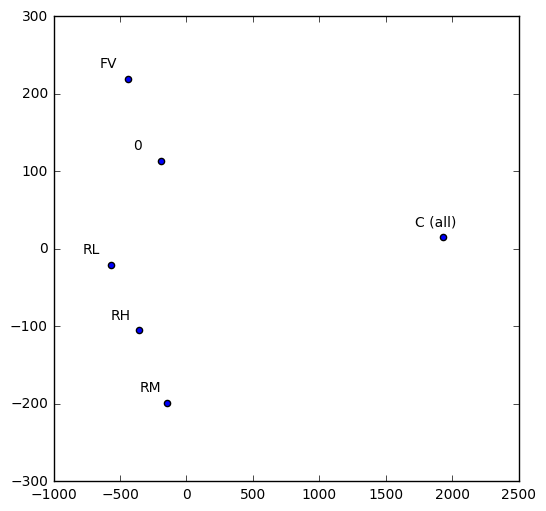

In [33]:
MSZoning_weights = mweights[1]
MSZoning = sorted(set(rawfull.MSZoning.values))
x = tsne.fit_transform(MSZoning_weights)
generate_plot(x, MSZoning)